In [1]:
from netgen.occ import *
from ngsolve import *
from netgen.meshing import IdentificationType
from MS_helper_functions import *
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw

from myPackage import cmdInput
import matplotlib.pyplot as plt
%matplotlib widget
plt.ioff()
from myPackage import evalOnLine


from meshGen import mesh2DLaminates

In [2]:
lambda1 = 1
lambda2 = 10

order0 = 2

In [3]:
D = 0.04
d = 0.02

ff = 0.7


numSheets = 4

maxh_edges = d/numSheets*1/2 * 0.05



modelHalfAir=True



## 1. Only Smooth
### 1.1. Reference Solution Only Smooth

In [4]:
cMeshRef = mesh2DLaminates(D, d, ff, numSheets, multiscale=False, onlySmooth=True, maxh_edges=maxh_edges*10, fullProblemX=True, rotated=True, modelHalfAir=modelHalfAir)
meshRef = cMeshRef.mesh
print("Boundaries", set(meshRef.GetBoundaries()))
print("Materials", set(meshRef.GetMaterials()))
Draw(meshRef.ngmesh)

maxh_edges [0.00125, 0.00125]
Boundaries {'itop', 'ibottom', 'right', 'bottom', 'top', 'left', 'default'}
Materials {'inner', 'outer', 'insulation'}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'mesh_dim': 2, 'mesh_cent…

BaseWebGuiScene

In [5]:
lam = meshRef.MaterialCF({"inner":lambda2, "outer":lambda1, "insulation":lambda1, "gap":lambda1, "multiscale":lambda2})
def calcRef():
    fes = H1(meshRef, order=order0, dirichlet="bottom|top")

    u,v = fes.TnT()
    sol = GridFunction(fes)

    a = BilinearForm(fes, symmetric=True)
    f = LinearForm(fes)

    a += lam * grad(u) * grad(v) * dx

    prec = Preconditioner(a, "direct")


    sol.Set(1 * y/Norm(y), BND)
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)
    
    
    energy =  Integrate( InnerProduct(lam * grad(sol), grad(sol)), meshRef, definedon=meshRef.Materials("inner|insulation"))
    
    return sol, energy

sol_ref, energy_ref = calcRef()


CG iteration 1, residual = 2.442251607749033     
CG iteration 2, residual = 9.97405833625478e-15     


In [6]:


print(f"energy:\t{energy_ref}")
Draw(sol_ref, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})
Draw( -grad(sol_ref)[1], meshRef, settings={"Objects":{"Wireframe":True}, "deformation": False})


energy:	0.7885342852576005


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

BaseWebGuiScene

### 1.2 Multiscale only Smooth

In [7]:

cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="multiscale", onlySmooth=True,  maxh_edges=[maxh_edges, maxh_edges*10], rotated=True)
# cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="smoothFrame", onlySmooth=onlySmooth)
meshMS = cMeshMS.mesh
print(meshMS.GetMaterials())
Draw(meshMS.ngmesh)


from myPackage import drawBndAll

# drawBndAll(meshMS, drawFunc=Draw, block=False)


maxh_edges [0.000125, 0.00125]
('outer', 'outer', 'multiscale')


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'mesh_dim': 2, 'mesh_cent…

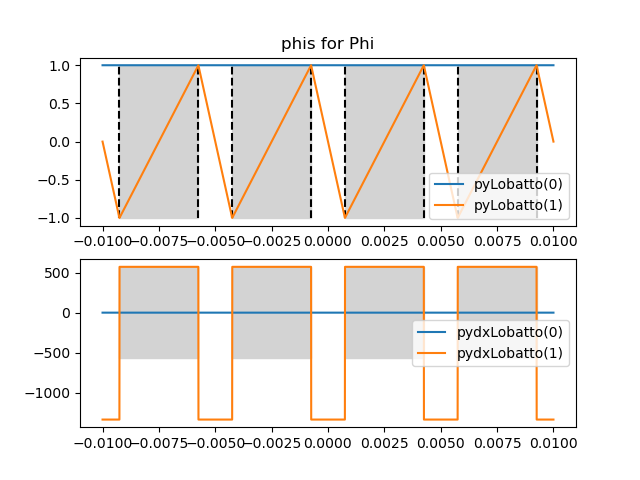

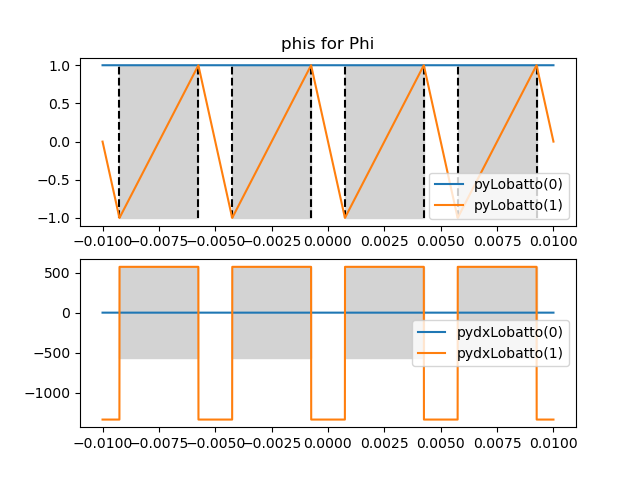

CG iteration 1, residual = 3.1640651447784562     
CG iteration 2, residual = 2.960477876538247e-14     
anorm 1235.692246936285
energy 0.7872849425381065 0.7885342852576005
1.586074484613767e-07
-grad(Phi0_outer) - grad(Phi1 * pyLobatto(0)) - grad(Phi2 * pyLobatto(1))


In [8]:
cl_Phi.numSheets = numSheets
cl_Phi.dFe = cMeshMS.dFe
cl_Phi.d0 = cMeshMS.d0
cl_Phi.mesh = meshMS

cl_Phi.modelHalfAir = modelHalfAir
cl_Phi.orientation = 1


force_full_Phi = True
moartaring = True

def calcMultiscale(useGradients=True, drawPhis=True):

    smoothbnd = "itop|ibottom"
    # microshape functions
    orderPhi = [
            cl_Phi(0, fes_order=1, material="multiscale", dirichlet="top|bottom", useGradients=True, useAbsolutes=False), 
            cl_Phi(1, fes_order=order0, material="multiscale", dirichlet="", useGradients=useGradients), 
            # cl_Phi(2, fes_order=order0, material="multiscale", dirichlet="", inAir=False, modelHalfAir=True), 
            # cl_Phi(2, fes_order=order0, material="multiscale", dirichlet="", inIron=False, modelHalfAir=True), 
        ]


    if not moartaring:
        orderPhi = orderPhi[1:]

    if drawPhis:
        cl_Phi.plotEvaluated(orderPhi)
        cl_Phi.plotDirectEvaluated(orderPhi)



    VSpace = []
    # u0 
    domains_outer = "outer"
    if not moartaring:
        domains_outer += "|multiscale"
    VSpace.append(H1(meshMS, order=order0, dirichlet="top|bottom", definedon=meshMS.Materials(domains_outer))) 
    
        
    # ui * phi i
    for phi_i in orderPhi: 
        VSpace.append(H1(meshMS, order=phi_i.fes_oder, definedon=meshMS.Materials(phi_i.material), dirichlet=phi_i.dirichlet))
    VSpace = FESpace(VSpace)


    # multiscale container
    ansatz = ""
    sol = GridFunction(VSpace, "sol")
       

    cl_gradgradMS = gradgradMS(orderPhi, sol, addPhi0Outer=True)

    cl_gradgradMS.generateCouplingMatrix(lambda2, lambda1, force_full_Phi=force_full_Phi)

    # for phi_a in cl_gradgradMS.coupling_matrix.keys():
    #     for phi_b in cl_gradgradMS.coupling_matrix[phi_a].keys():
    #         if (phi_a.order == 1 and phi_b.order == 2) or (phi_a.order == 2 and phi_b.order == 1):
    #             cl_gradgradMS.coupling_matrix[phi_a][phi_b] = 0



    a = BilinearForm(VSpace, symmetric=True)
    f = LinearForm(VSpace)

    a += lambda1  * grad(cl_gradgradMS.trials[0]) * grad(cl_gradgradMS.tests[0]) * dx("outer")
    a += cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu, cl_gradgradMS.gradv, lambda2, lambda1, force_full_Phi=force_full_Phi) * dx("multiscale")

    alpha = 3.5
    h = specialcf.mesh_size

    u_start = 1 if moartaring else 0
    alpha = 3
    d_coupling = -d/2 if modelHalfAir else -d/2 + cl_Phi.d0/2


    # absolutes
    u_range = range(u_start, len(cl_gradgradMS.u))
    u_range = [1]
    um_bottom = sum(cl_gradgradMS.u[i][0] * cl_gradgradMS.u[i][1].DirectEvaluate(-d_coupling) for i in u_range)
    vm_bottom = sum(cl_gradgradMS.v[i][0] * cl_gradgradMS.v[i][1].DirectEvaluate(-d_coupling) for i in u_range)

    um_top = sum(cl_gradgradMS.u[i][0] * cl_gradgradMS.u[i][1].DirectEvaluate(d_coupling) for i in u_range)
    vm_top = sum(cl_gradgradMS.v[i][0] * cl_gradgradMS.v[i][1].DirectEvaluate(d_coupling) for i in u_range)

    jump_u_top = cl_gradgradMS.u[0][0] - um_top
    jump_u_bottom = cl_gradgradMS.u[0][0] - um_bottom

    jump_v_top = cl_gradgradMS.v[0][0] - vm_top
    jump_v_bottom = cl_gradgradMS.v[0][0] - vm_bottom

    # gradients
    grad_range = range(u_start, len(cl_gradgradMS.gradu))
    
    gradum_bottom = sum(cl_gradgradMS.gradu_trace_n[i][0] * cl_gradgradMS.gradu_trace_n[i][1].DirectEvaluate(-d_coupling) for i in grad_range)
    gradvm_bottom = sum(cl_gradgradMS.gradv_trace_n[i][0] * cl_gradgradMS.gradv_trace_n[i][1].DirectEvaluate(-d_coupling) for i in grad_range)

    gradum_top = sum(cl_gradgradMS.gradu_trace_n[i][0] * cl_gradgradMS.gradu_trace_n[i][1].DirectEvaluate(d_coupling) for i in grad_range)
    gradvm_top = sum(cl_gradgradMS.gradv_trace_n[i][0] * cl_gradgradMS.gradv_trace_n[i][1].DirectEvaluate(d_coupling) for i in grad_range)

    jump_Bu_top = lambda1 * cl_gradgradMS.gradu_trace_n[0][0] - lambda2 * gradum_top
    jump_Bu_bottom = lambda1 * cl_gradgradMS.gradu_trace_n[0][0] - lambda2 * gradvm_bottom

    jump_Bv_top = lambda1 * cl_gradgradMS.gradv_trace_n[0][0] - lambda2 * gradvm_top
    jump_Bv_bottom = lambda1 * cl_gradgradMS.gradv_trace_n[0][0] - lambda2 * gradvm_bottom

    # couple u
    if True:
        #[u][v]
        # a += alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[u_start:], cl_gradgradMS.v[u_start:],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[u_start:], cl_gradgradMS.v[:1],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[:1], cl_gradgradMS.v[:1],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[:1], cl_gradgradMS.v[u_start:],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)

        a += alpha*order0**2/h  * (jump_u_top)  * (jump_v_top)  *ds("itop")
        a += alpha*order0**2/h  * (jump_u_bottom)  * (jump_v_bottom)  *ds("ibottom")
        

    if False:
        #{dn u } [ v]
        # a += -cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[u_start:], cl_gradgradMS.v[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[u_start:], cl_gradgradMS.v[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[:1], cl_gradgradMS.v[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[:1], cl_gradgradMS.v[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += (lambda2 * jump_gradu_top)  * (jump_v_top)  *ds("itop")
        a += (lambda2 * jump_gradu_bottom)  * (jump_v_bottom)  *ds("ibottom")


        #[ u] {dn v } 
        # a += -cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[u_start:], cl_gradgradMS.gradv_trace_n[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[u_start:], cl_gradgradMS.gradv_trace_n[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[:1], cl_gradgradMS.gradv_trace_n[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[:1], cl_gradgradMS.gradv_trace_n[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += (lambda2 * jump_gradv_top)  * (jump_u_top)  *ds("itop")
        a += (lambda2 * jump_gradv_bottom)  * (jump_u_bottom)  *ds("ibottom")

    # couple fluxes
    if False:
        # [dn u] [ dn v]
        # a += alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[u_start:], cl_gradgradMS.gradv_trace_n[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[u_start:], cl_gradgradMS.gradv_trace_n[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[:1], cl_gradgradMS.gradv_trace_n[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[:1], cl_gradgradMS.gradv_trace_n[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)

        a += alpha*order0**2/h  * (jump_Bu_top)  * (jump_Bv_top)  *ds("itop")
        a += alpha*order0**2/h  * (jump_Bu_bottom)  * (jump_Bv_bottom)  *ds("ibottom")


    # couple hesse 
    if False:

        #{gradgrad(u)_n_n } [ dn v]
        a += -cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.hesse_u_trace_nn, cl_gradgradMS.gradv_trace_n,  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.hesse_u_trace_nn, [cl_gradgradMS.gradv_trace_n[0]],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += cl_gradgradMS.getIntegrand4BFI([cl_gradgradMS.hesse_u_trace_nn[0]], cl_gradgradMS.gradv_trace_n,  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -cl_gradgradMS.getIntegrand4BFI([cl_gradgradMS.hesse_u_trace_nn[0]], [cl_gradgradMS.gradv_trace_n[0]],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)


        #[ dn u] {gradgrad(v)_n_n } 
        a += -cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n, cl_gradgradMS.hesse_v_trace_nn,  lambda2, lambda1, force_full_Phi=True)  *ds(smoothbnd)
        a += cl_gradgradMS.getIntegrand4BFI([cl_gradgradMS.gradu_trace_n[0]], cl_gradgradMS.hesse_v_trace_nn,  lambda2, lambda1, force_full_Phi=True)  *ds(smoothbnd)
        a += cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n, [cl_gradgradMS.hesse_v_trace_nn[0]],  lambda2, lambda1, force_full_Phi=True)  *ds(smoothbnd)
        a += -cl_gradgradMS.getIntegrand4BFI([cl_gradgradMS.gradu_trace_n[0]], [cl_gradgradMS.hesse_v_trace_nn[0]],  lambda2, lambda1, force_full_Phi=True)  *ds(smoothbnd)

    prec = Preconditioner(a,type="direct")  


    # dirichlet boundary values
    sol.components[0].Set(1 * y/Norm(y), BND)
    if moartaring:
        sol.components[1].Set(1 * y/Norm(y), BND)
    
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)

    print("anorm", a.mat.AsVector().Norm())

    energy =  Integrate(getIntegrand4BFI(cl_gradgradMS.gradsol_pack, cl_gradgradMS.gradsol_pack, lambda2, lambda1), meshMS, 
                                                    definedon=meshMS.Materials("multiscale"))
    
    return sol, cl_gradgradMS.sol_pack, cl_gradgradMS.sol_comp, cl_gradgradMS.gradsol_comp, energy, cl_gradgradMS

    

sol_MS, sol_pack_MS, sol_comp_MS, H_comp, energy_MS, cl_gradgradMS = calcMultiscale(useGradients=True, drawPhis=True)
print("energy", energy_MS, energy_ref)
print(Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))
print(cl_gradgradMS.ansatz)



In [9]:
cl_gradgradMS.printGradGradMatrix();

          dx_v_0    dy_v_0    dx_v_0    dy_v_0             v_1    dx_v_1    dy_v_1
------  --------  --------  --------  --------  --------------  --------  --------
dx_u_0       7.3       0         7.3       0       0            -0         0
dy_u_0       0         7.3       0         7.3  3600             0        -0
dx_u_0       7.3       0         7.3       0       0            -0         0
dy_u_0       0         7.3       0         7.3  3600             0        -0
u_1          0      3600         0      3600       2.81905e+06   0        -0
dx_u_1      -0         0        -0         0       0             2.43333   0
dy_u_1       0        -0         0        -0      -0             0         2.43333


In [10]:
cl_gradgradMS.printCouplingMatrix();
assert cl_gradgradMS.checkCouplingMatrxiSymmetric(1e-3) == True


                    0             1             2               3
--  --------------  ------------  ------------  --------------  ------------
                    pyLobatto(0)  pyLobatto(0)  pydxLobatto(1)  pyLobatto(1)
0   pyLobatto(0)    7.3           7.3           3600.0          -0.0
1   pyLobatto(0)    7.3           7.3           3600.0          -0.0
2   pydxLobatto(1)  3600.0        3600.0        2819047.619     -0.0
3   pyLobatto(1)    -0.0          -0.0          -0.0            2.433


In [16]:
print(sol_pack_MS[0][1].order)
i = 0
print(sol_pack_MS[i][1].name)
# Draw(sol_pack_MS[i][0], meshRef, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})

Draw(sum(sol_comp_MS), meshRef, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})

0
pyLobatto(0)


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

BaseWebGuiScene

### 1.3 Comparison 

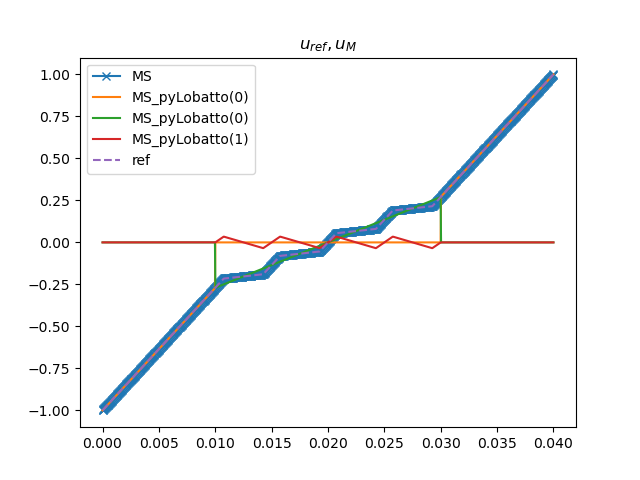

In [12]:


start = -d/2*1.01
end = -d/2*0.9

# start = d/2*0.95
# end = d/2*1.02


plt.figure(2)
start = -D/2
end = D/2



evalOnLine(sum(sol_comp_MS) , meshRef, [0, start, 0], [0, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);

[evalOnLine(sol_comp_MS[i] , meshRef, [0, start, 0], [0, end, 0], plot=True, ls='-', marker="", clear=False, label="MS_"+sol_pack_MS[i][1].name, show=False, N=1000) for i in range(len(sol_comp_MS))];
evalOnLine(sol_ref , meshRef, [0, start, 0], [0, end, 0], plot=True, ls='--', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$u_{ref}, u_{M}$");


plt.legend()
plt.show()



In [13]:
energy =  Integrate(getIntegrand4BFI(cl_gradgradMS.gradsol_pack, cl_gradgradMS.gradsol_pack, lambda2, lambda1), meshMS, 
                                                definedon=meshMS.Materials("multiscale"))

cl_gradgradMS.gradsol_pack[0][0]                                         

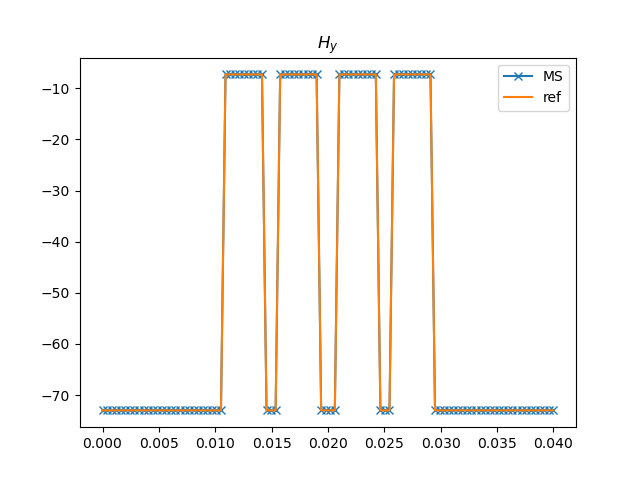

In [14]:
start = -D/2
end = D/2


plt.figure(3)
evalOnLine(sum(H_comp)[1] , meshRef, [0, start, 0], [0, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=100, title=r"$H_y$");
evalOnLine(-grad(sol_ref)[1] , meshRef, [0, start, 0], [0, end, 0], plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 100, title=r"$H_y$");


plt.legend()
plt.show()

In [15]:
print("Norm soll diff", Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))
print("diff energy", energy_MS, energy_ref, energy_MS - energy_ref, f"{(energy_MS - energy_ref)/energy_ref * 100}%" )


Norm soll diff 1.586074484613767e-07
diff energy 0.7872849425381065 0.7885342852576005 -0.001249342719493951 -0.15843860474447377%
